# Climate Data Store (CDS) - Example Frontend

**Contains modified Copernicus Climate Change Service Information 2020**
under [License](https://apps.ecmwf.int/datasets/licences/copernicus/)

*Copernicus Climate Change Service (C3S) - Upper Air Data Service (2020)*

The purpose of this IPython Notebook is to demonstrate the access and usability of the proposed data delivering service. Example usage of the Climate Data Store (CDS) Frontend for Radiosonde data.

    Author: M. Blaschek
    Date: 07.2020
    Contact: michael.blaschek [at] univie.ac.at
    License: C3S, 2020

In [1]:
# check if necessary packages are install
!pip -q install numpy pandas xarray matplotlib 

In [2]:
%pylab inline
import warnings
warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


# Functionality via the CDSAPI

The backend is called via the `cdsapi` and requests the data.

The frontend returns one zip files, which contains one of the following:
1. CF 1.7 compliant netCDF4 files (one per station and per variable).
2. CSV files (one per variable)

A typical request should contain:
1. **statid** - the Station Identifier
    * e.g. `'11035' or ['11035','72357'] or 'all'`
2. **date** - Date
    * e.g. `YYYYMMDD like 19990131`
2. **year** - Year
    * e.g. `1999`
3. **month** - Month
    * e.g. `02`
4. **day** - Day
    * e.g. `01, 02, ...`
5. **period** - datetime range
    * e.g. `a range '1999-01-01/1999-12-31'  for all data in 1999'
6. **pressure_level** - selection of pressure levels in hPa
    * e.g. `one level ['850'] or ['500', '850'] or no keyword for all significant levels`
7. **variable** - selection of variables 
    * e.g. `air_temperature, air_relative_humidity, air_specific_humidity, zonal_wind, meridional_wind, wind_speed, wind_direction`
8. **fbstats**  - feedback information from reanalysis
    * e.g. `obs_minus_an, obs_minus_fg, bias_estimate`
9. **country** - request all stations from a country
    * e.g. `DEU, USA, GBR, ...`
10. **bbox** - request all stations within a bounding box 
    * e.g. `[lower left upper right] like [40 0 50 20] for Europe`
    * `lower<upper, left<right, -90<=lat<=90, -180<=lon<=360`

## CDSAPI Access

The CDSAPI requires a `.cdsapirc` file. Please [register](https://cds.climate.copernicus.eu/user/register?destination=%2F%23!%2Fhome) at the CDS and follow the "[How-to](https://cds.climate.copernicus.eu/api-how-to)" to allow the API access.

## Example Request - One Profile

The requested data will be downloaded and unzipped into the `example_data` directory.

**Update: Please note that the request did hardly change from the backend-version.** Which can be found here: [Example-backend](https://github.com/MBlaschek/CEUAS/blob/master/CEUAS/public/cds-backend/Example.ipynb)

In [3]:
import cdsapi, zipfile, os, time
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning) # just cosmetics

# Please note: Server URL will be omitted, once published
c = cdsapi.Client(url='https://sis-dev.climate.copernicus.eu/api/v2')

In [4]:
t0 = time.time()
# Start Request
r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
               {
                   'variable': ["air_temperature", "air_relative_humidity"],
                   'year': '2000',
                   'month':'02',
                   'day':'01',
                   'statid': '10393',
                   'fbstats': ["obs_minus_bg", "obs_minus_an", "bias_estimate"],
               })
# Start Download
r.download(target='download.zip')
# Check file size
assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
# Unzip the Data Stream
z = zipfile.ZipFile('download.zip')
print("Unzipping retrieved files: to ./exampla_data/1")
print(z.namelist())
z.extractall(path='./example_data/1')
z.close()
os.remove('download.zip')
print("Time elapsed: ", time.time()-t0, "s")

2020-07-09 15:47:56,305 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-07-09 15:47:56,668 INFO Request is completed
2020-07-09 15:47:56,670 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1594120569.3622072-29885-12-783d2683-9524-4006-b0ad-1ee78fbbb355.zip to download.zip (73.1K)
2020-07-09 15:47:56,900 INFO Download rate 319.4K/s


Unzipping retrieved files: to ./exampla_data/1
['dest_0-20000-0-10393_air_temperature.nc', 'dest_0-20000-0-10393_relative_humidity.nc']
Time elapsed:  0.6018576622009277 s


In [5]:
# Show the new downloaded files in example_data directory
!ls -Rlh example_data/1

example_data/1:
total 1.4M
-rw-r--r--. 1 mblaschek users  37K Jul  9 15:47 dest_0-20000-0-10393_air_temperature.nc
-rw-r--r--. 1 mblaschek users  37K Jul  9 15:47 dest_0-20000-0-10393_relative_humidity.nc
-rw-r--r--. 1 mblaschek users 638K Jul  9 11:01 relative_humidity.csv
-rw-r--r--. 1 mblaschek users 621K Jul  9 11:01 temperature.csv


## Retrieved files

In [6]:
import xarray as xr

In [7]:
# Open Netcdf with Xarray
tdata = xr.open_dataset('example_data/1/dest_0-20000-0-10393_air_temperature.nc')
print(tdata)

<xarray.Dataset>
Dimensions:           (obs: 227, string10: 10, trajectory: 4)
Coordinates:
    lat               (obs) float32 ...
    lon               (obs) float32 ...
  * obs               (obs) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    plev              (obs) float32 ...
  * string10          (string10) |S1 b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
    time              (obs) datetime64[ns] ...
  * trajectory        (trajectory) int32 0 0 0 0
Data variables:
    bias_estimate     (obs) float32 ...
    obs_minus_an      (obs) float32 ...
    obs_minus_bg      (obs) float32 ...
    ta                (obs) float32 ...
    trajectory_index  (obs) int32 ...
    trajectory_label  (trajectory, string10) |S1 ...
Attributes:
    primary_id:    0-20000-0-10393
    station_name:  LINDENBERG (10393-0)
    Conventions:   CF-1.7
    source:        radiosonde
    featureType:   trajectory
    history:       Created by Copernicus Early Upper Air Service Version 0, 0...
    license:  

## Variables

Notice that there are the following variables:
* `bias_estimate` - Reanalysis Bias estimate
* `obs_min_an` - Analysis Departures
* `obs_min_bg` - First Guess Departures
* `ta` - Observations, e.g. Air Temperature
* `trajectory_index` - unique profile identifier, where each observation belongs to
* `trajectory_label` - unique profile label, as in the CDM tables

Notice as well the Dimensions:
* `obs` - Dimension that corresponds to a record lenght (all profiles together)
* `trajectory`  - Dimension that corresponds to a number of individual profiles

and Coordinates:
* `lat` - Coordinate Information Latitude
* `lon` - Coordinate Information Longitude
* `plev` - Coordinate Information pressure
* `time` - Coordinate Information time

## Request a csv file

In [8]:
t0 = time.time()
# Start Request
r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
               {
                   'variable': ["air_temperature", "air_relative_humidity"],
                   'year': '2000',
                   'month':'02',
                   'day':'01',
                   'statid': '10393',
                   'format': 'csv'
               })
# Start Download
r.download(target='download.zip')
# Check file size
assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
# Make Output directories
os.makedirs('./example_data/1', exist_ok=True)
#
# Unzip the Data Stream
#
z = zipfile.ZipFile('download.zip')
print("Unzipping retrieved files: to ./exampla_data/1")
print(z.namelist())
z.extractall(path='./example_data/1')
z.close()
os.remove('download.zip')
print("Time elapsed: ", time.time()-t0, "s")

2020-07-09 15:47:58,904 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-07-09 15:47:59,013 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1594120663.2623515-29660-12-2b6fa125-73b1-4116-9d6b-8896560ab383.zip to download.zip (51.6K)
2020-07-09 15:47:59,172 INFO Download rate 326.3K/s


Unzipping retrieved files: to ./exampla_data/1
['temperature.csv', 'relative_humidity.csv']
Time elapsed:  0.2861959934234619 s


In [9]:
!ls -Rlh example_data/1

example_data/1:
total 1.4M
-rw-r--r--. 1 mblaschek users  37K Jul  9 15:47 dest_0-20000-0-10393_air_temperature.nc
-rw-r--r--. 1 mblaschek users  37K Jul  9 15:47 dest_0-20000-0-10393_relative_humidity.nc
-rw-r--r--. 1 mblaschek users 638K Jul  9 15:47 relative_humidity.csv
-rw-r--r--. 1 mblaschek users 621K Jul  9 15:47 temperature.csv


In [10]:
import pandas

In [11]:
pandas.set_option('expand_frame_repr', False)

In [12]:
tdata = pandas.read_csv('example_data/1/temperature.csv', index_col=0)
print(tdata.dropna(subset=['ta']))

          lat    lon     plev     ta                 time  trajectory_index           statid  statindex
obs_id                                                                                                 
0       52.22  14.12   4260.0  200.3  2000-02-01 05:00:00                 0  0-20000-0-10393          0
1       52.22  14.12   4260.0  200.3  2000-02-01 05:00:00                 0  0-20000-0-10393          0
2       52.22  14.12   4260.0  200.3  2000-02-01 05:00:00                 0  0-20000-0-10393          0
3       52.22  14.12   4260.0  200.3  2000-02-01 05:00:00                 0  0-20000-0-10393          0
4       52.22  14.12   4260.0  200.3  2000-02-01 05:00:00                 0  0-20000-0-10393          0
...       ...    ...      ...    ...                  ...               ...              ...        ...
9035    52.22  14.12  96100.0  278.2  2000-02-01 23:00:00                 3  0-20000-0-10393          0
9036    52.22  14.12  96100.0  278.2  2000-02-01 23:00:00       

# Plot a profile

Read data from the [Example Request](#Example-Request---One-Profile) and make a plot.

## Read the NetCDF to xarray

In [13]:
# In case of NetCDF error might need to run again (unknown bug)
tdata = xr.load_dataset('example_data/1/dest_0-20000-0-10393_air_temperature.nc')
rdata = xr.load_dataset('example_data/1/dest_0-20000-0-10393_relative_humidity.nc')

In [14]:
# This is the xarray representation of the NetCDF file
print(tdata)

<xarray.Dataset>
Dimensions:           (obs: 227, string10: 10, trajectory: 4)
Coordinates:
    lat               (obs) float32 52.22 52.22 52.22 ... 52.22 52.22 52.22
    lon               (obs) float32 14.12 14.12 14.12 ... 14.12 14.12 14.12
  * obs               (obs) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    plev              (obs) float32 4260.0 5000.0 5180.0 ... 96100.0 100000.0
  * string10          (string10) |S1 b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
    time              (obs) datetime64[ns] 2000-02-01T05:00:00 ... 2000-02-01T23:00:00
  * trajectory        (trajectory) int32 0 0 0 0
Data variables:
    bias_estimate     (obs) float32 -0.06314654 -0.070816316 nan ... 0.0 0.0 nan
    obs_minus_an      (obs) float32 -1.2742708 1.3983693 nan ... 0.53500205 nan
    obs_minus_bg      (obs) float32 -1.4799681 0.6554459 nan ... 1.1662796 nan
    ta                (obs) float32 200.3 203.7 nan 205.3 ... 278.2 278.2 nan
    trajectory_index  (obs) int32 0 0 0 0 0 0 0 0 0

## Plot a profile

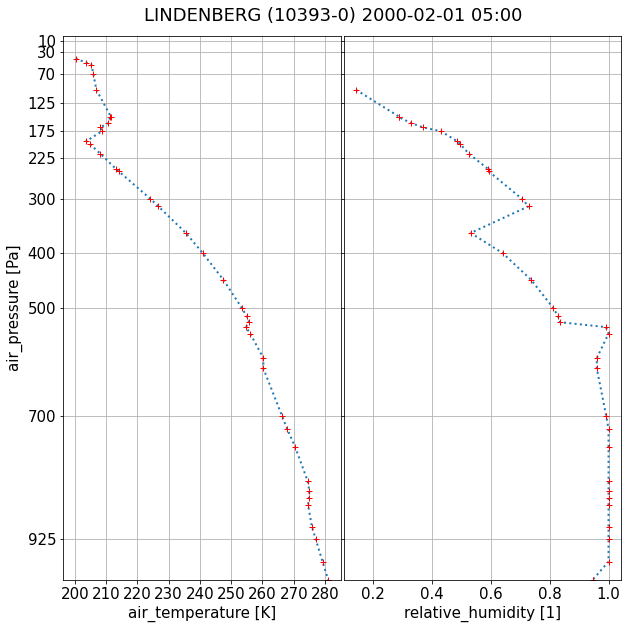

In [15]:
yplevs = np.array([10,30,70,125,175,225,300,400,500,700,925])*100.
#
# Select first profile, change dimension to pressure, drop missing values
#
plotdata = tdata.sel(obs=tdata.trajectory_index==0).ta.swap_dims({'obs':'plev'}).to_dataset()
plotdata['hur'] = rdata.sel(obs=rdata.trajectory_index==0).hur.swap_dims({'obs':'plev'})
#
# Plotting
#
with plt.style.context({'font.size': 15, 'lines.linewidth': 2}):
    f, [ax,ay] = subplots(1,2, sharey=True, figsize=(10,10))
    plotdata.ta.dropna('plev').plot(y='plev', marker='+', ls=':', mec='red', ax=ax)
    plotdata.hur.dropna('plev').plot(y='plev', marker='+', ls=':', mec='red', ax=ay)
    # ax.set_yscale('log')
    ax.set_yticks(ticks=yplevs)
    ax.set_yticklabels(map("{:.0f}".format,yplevs/100))
    ax.set_ylim(100000,100)
    ay.set_ylim(100000,100)
    ax.grid()
    ay.grid()
    ay.set_ylabel('')
    subplots_adjust(wspace=0.01)
    f.suptitle("{} {}".format(tdata.attrs['station_name'], plotdata.time.dt.strftime("%Y-%m-%d %H:%M").item(0)),y=0.92);

# Request a timeseries

Tasks:
* One Station: `10393`
* Datetime range: ` '20000101-20181231' ` 
* One variables: `air_temperature`
* One pressure level: `500` hPa


In [16]:
t0 = time.time()
# Start Request
r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
               {
                   'variable': ["air_temperature"],
                   'period': '2000-01-01/2019-12-31',
                   'pressure_level': '500',
                   'statid': '10393',
               })
# Start Download
r.download(target='download.zip')
# Check file size
assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
# Unzip the Data Stream
z = zipfile.ZipFile('download.zip')
print("Unzipping retrieved files: to ./exampla_data/2")
print(z.namelist())
z.extractall(path='./example_data/2')
z.close()
os.remove('download.zip')
print("Time elapsed: ", time.time()-t0, "s")

2020-07-09 15:48:00,610 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-07-09 15:48:00,782 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1594287301.7624476-16386-11-2a2f6c7c-62a6-4eac-9a92-8fefff6dae08.zip to download.zip (499.1K)
2020-07-09 15:48:01,128 INFO Download rate 1.4M/s 


Unzipping retrieved files: to ./exampla_data/2
['dest_0-20000-0-10393_air_temperature.nc']
Time elapsed:  0.5272457599639893 s


## Read NetCDF to xarray

In [17]:
tdata = xr.load_dataset('example_data/2/dest_0-20000-0-10393_air_temperature.nc')

In [18]:
# Again the representation of the NetCDF file, 
# Notice the number of trajectories (13879), this is basically the amount of profiles in the file.
print(tdata)

<xarray.Dataset>
Dimensions:           (obs: 29112, string10: 10, trajectory: 29109)
Coordinates:
    lat               (obs) float32 52.22 52.22 52.22 ... 52.2093 52.2093
    lon               (obs) float32 14.12 14.12 14.12 ... 14.12041 14.12041
  * obs               (obs) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    plev              (obs) float32 50000.0 50000.0 50000.0 ... 50000.0 50000.0
  * string10          (string10) |S1 b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
    time              (obs) datetime64[ns] 2000-01-01T05:00:00 ... 2019-12-31T16:45:10
  * trajectory        (trajectory) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Data variables:
    ta                (obs) float32 250.1 250.7 246.3 ... 249.93 249.93 249.09
    trajectory_index  (obs) int32 0 1 2 3 4 5 ... 29104 29105 29106 29107 29108
    trajectory_label  (trajectory, string10) |S1 b'0' b'0' b'0' ... b'4' b'0'
Attributes:
    primary_id:    0-20000-0-10393
    station_name:  LINDENBERG (10393-0)
    Con

## Plot a timeseries

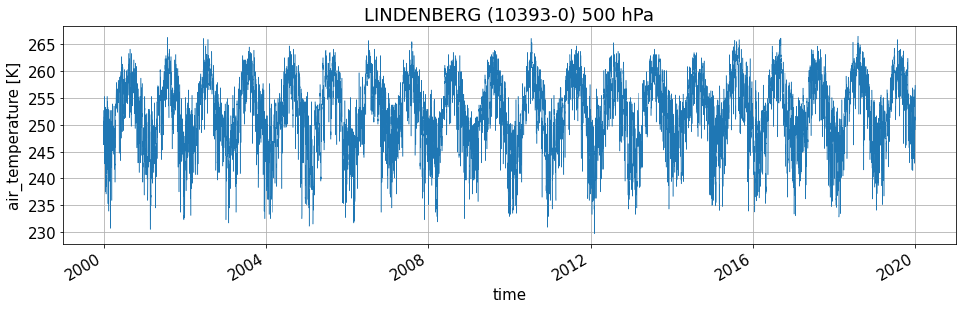

In [19]:
#
# Select 00Z, change dimension to pressure, drop missing values
#
plotdata = tdata.ta.swap_dims({'obs':'time'}).to_dataset()
#
# Plotting
#
with plt.style.context({'font.size': 15, 'lines.linewidth': 0.5, 'figure.figsize':(16,4)}):
    plotdata.ta.dropna('time').plot(x='time')
    grid()
    title("{} {:.0f} hPa".format(tdata.attrs['station_name'], plotdata.plev.values[0]/100));

# Request Country
Select radiosondes based on a country code:
* `GLOBE` or `ALL`
* `DEU` for Germany
* `AUT` for Austria
* `GBR` for Great Britain
* `USA` for United States of America

for further Codes and details please search at WMO's [OSCAR](https://oscar.wmo.int/surface/#/)

Tasks:
* Country: `DEU` for Germany
* One day: `20000101 - 20000101`
* Two variables: `temperature`
* One pressure level: `85000`

In [20]:
t0 = time.time()
# Start Request
r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
               {
                   'variable': ["air_temperature"],
                   'year': '2000',
                   'month': '01',
                   'day': '01',
                   'pressure_level': '850',
                   'country': 'DEU',
               })
# Start Download
r.download(target='download.zip')
# Check file size
assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
# Unzip the Data Stream
z = zipfile.ZipFile('download.zip')
print("Unzipping retrieved files: to ./exampla_data/3")
print(z.namelist())
z.extractall(path='./example_data/3')
z.close()
os.remove('download.zip')
print("Time elapsed: ", time.time()-t0, "s")

2020-07-09 15:48:01,812 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-07-09 15:48:01,994 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1594287897.7853274-16011-10-49ede37e-9b81-4ba2-90e9-f1b0d9b0931d.zip to download.zip (251.7K)
2020-07-09 15:48:02,387 INFO Download rate 642.8K/s


Unzipping retrieved files: to ./exampla_data/3
['dest_0-20000-0-10393_air_temperature.nc', 'dest_0-20000-0-10200_air_temperature.nc', 'dest_0-20000-0-10035_air_temperature.nc', 'dest_0-20000-0-10184_air_temperature.nc', 'dest_0-20000-0-10548_air_temperature.nc', 'dest_0-20000-0-10739_air_temperature.nc', 'dest_0-20000-0-10410_air_temperature.nc', 'dest_0-20000-0-10618_air_temperature.nc', 'dest_0-20000-0-10771_air_temperature.nc', 'dest_0-20000-0-10868_air_temperature.nc']
Time elapsed:  0.5855770111083984 s


## Read NetCDF to xarray

In [21]:
data = {}
ipath = './example_data/3/'
for ifile in os.listdir(ipath):
    ident = ifile.split('_')[1]
    
    if ident not in data.keys():
        data[ident] = []
    #
    # Load the NetCDF data
    #
    tmp = xr.load_dataset(ipath + ifile)
    #
    # Add Sonde ID as coordinate
    #
    tmp.coords['sonde'] = ident
    #
    # Drop
    #
    tobedropped=[]
    for ivar in list(tmp.data_vars) + list(tmp.coords):
        if 'trajectory' in ivar or 'string' in ivar:
            tobedropped.append(ivar)
    tmp = tmp.drop(tobedropped)
    #
    # Use time as dimension
    #
    tmp = tmp.swap_dims({'obs':'time'})
    data[ident].append(tmp)
#
# Merge Variables per Sonde into one Dataset
#
for ikey in data.keys():
    data[ikey] = xr.merge(data[ikey])
#
# Make a larger dataset
#
data = xr.concat(data.values(), dim='sonde')

In [22]:
print(data)

<xarray.Dataset>
Dimensions:  (sonde: 10, time: 7)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T23:00:00
    lat      (sonde, time) float32 nan 52.22 nan 52.22 ... 48.2442 nan 48.25
    lon      (sonde, time) float32 nan 14.12 nan 14.12 ... 11.5525 nan 11.55
    obs      (sonde, time) float64 nan 0.0 nan 0.0 nan ... nan 0.0 0.0 nan 0.0
    plev     (sonde, time) float32 nan 85000.0 nan ... 85000.0 nan 85000.0
  * sonde    (sonde) object '0-20000-0-10393' ... '0-20000-0-10868'
Data variables:
    ta       (sonde, time) float32 nan 265.9 nan 266.7 ... 268.65 nan 269.7


## Merged Dataset

Notice that we have 10 Sondes and 7 launch times.

In [23]:
print(data.ta)
print(data.ta.count('sonde'))

<xarray.DataArray 'ta' (sonde: 10, time: 7)>
array([[   nan, 265.9 ,    nan, 266.7 ,    nan, 268.9 , 270.9 ],
       [271.85,    nan,    nan, 271.9 , 271.85,    nan, 276.6 ],
       [269.65,    nan,    nan, 272.3 , 272.25,    nan, 275.2 ],
       [266.65,    nan,    nan, 267.5 , 267.45,    nan, 272.9 ],
       [268.05,    nan,    nan, 269.1 , 269.05,    nan, 269.5 ],
       [   nan,    nan,    nan, 269.7 , 269.65,    nan, 269.5 ],
       [270.85,    nan,    nan, 272.7 , 272.65,    nan,    nan],
       [271.05, 269.5 , 269.45, 272.5 , 272.45,    nan, 275.8 ],
       [266.65,    nan,    nan, 267.5 , 267.45,    nan, 268.1 ],
       [268.05,    nan,    nan, 268.7 , 268.65,    nan, 269.7 ]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T23:00:00
    lat      (sonde, time) float32 nan 52.22 nan 52.22 ... 48.2442 nan 48.25
    lon      (sonde, time) float32 nan 14.12 nan 14.12 ... 11.5525 nan 11.55
    obs      (sonde, time) float64 nan 0.0 nan

## Preparing plotdata

In order to have a common datetime we choose here to interpolate to 06Z as a common time.
To do this be need to fill the missing information and linearly interpolate to the time:
1. `interpolate_na`, interpolate missing values, only possible for Vienna, because 04Z and 05Z lie between 00Z and 12Z.
2. `ffill`, forward fill, copies the information to other times.
3. `interp`, linearly interpolates to the wanted time 06Z.
    - Note only for Vienna the value is interpolated between 05Z and 12Z

In [24]:
plotdata = data.interpolate_na('time')  # Interpolate
# reset_coords make lon, lat to variables and allows them to be filled as well, set_coords make lat,lon coordinates again, but filled with information now.
plotdata = plotdata.reset_coords(['lon', 'lat']).ffill('time').bfill('time').set_coords(['lon', 'lat'])
plotdata = plotdata.interp(time='2000-01-01 12:00:00')
print(plotdata.ta)

<xarray.DataArray 'ta' (sonde: 10)>
array([267.06668091, 271.8500061 , 272.25      , 267.45001221,
       269.04998779, 269.6499939 , 272.6499939 , 272.45001221,
       267.45001221, 268.6499939 ])
Coordinates:
  * sonde    (sonde) object '0-20000-0-10393' ... '0-20000-0-10868'
    obs      (sonde) float64 nan 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    plev     (sonde) float64 nan 8.5e+04 8.5e+04 ... 8.5e+04 8.5e+04 8.5e+04
    lon      (sonde) float64 14.12 7.227 9.55 13.41 ... 6.969 7.326 11.9 11.55
    lat      (sonde) float64 52.22 53.39 54.53 54.1 ... 51.41 49.69 49.43 48.24
    time     datetime64[ns] 2000-01-01T12:00:00


## Plot a map

In [25]:
# Cartopy can not easily be installed on Colab
import cartopy.crs as ccrs
import cartopy as cpy

[4.968599796295166, 16.119999885559082, 47.24420166015625, 55.53329849243164]


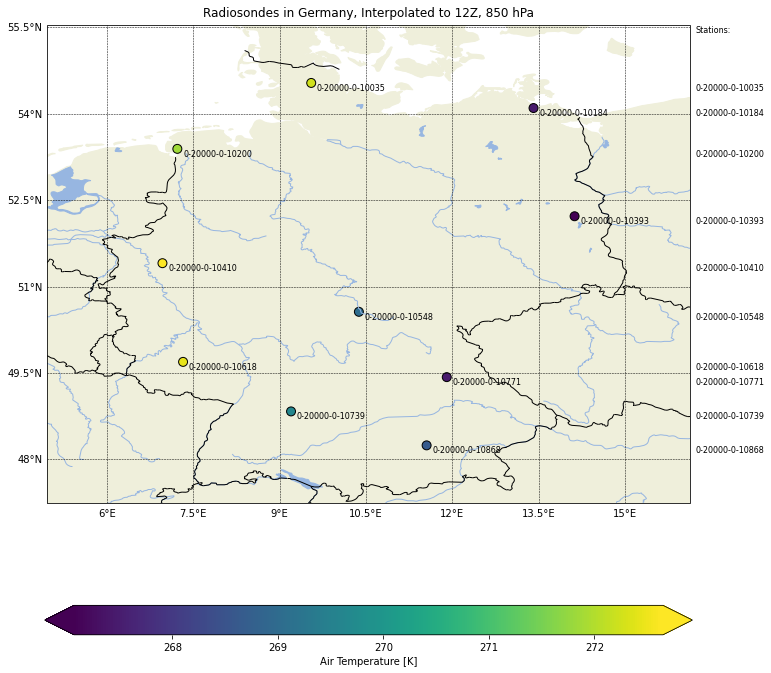

In [27]:
#
# Define the Plot
#
plt.figure(figsize=(10,10))
ax = plt.subplot(projection=ccrs.PlateCarree());
#
# Add Metainformation
#
ax.add_feature(cpy.feature.LAND, zorder=0)
ax.add_feature(cpy.feature.LAKES.with_scale('10m'), zorder=0)
ax.add_feature(cpy.feature.RIVERS.with_scale('10m'), zorder=1)
ax.add_feature(cpy.feature.BORDERS.with_scale('10m'), zorder=1)
#
# Plot the Values
#
cs = ax.scatter(plotdata.lon.values, plotdata.lat.values, 
                s=80,
                c=plotdata.ta.values,
                edgecolor='k',
                transform=ccrs.PlateCarree());
#
# Colorbar
#
cb = plt.colorbar(cs, ax=ax, extend='both', orientation='horizontal')
cb.set_label("Air Temperature [K]")
#
# Add Labels
#
lloffset = [0.1]*plotdata.sonde.size
boundary = [plotdata.lon.min().item()-2, plotdata.lon.max().item()+2, plotdata.lat.min().item()-1, plotdata.lat.max().item()+1]
print(boundary)
ax.text(boundary[1]+0.1, boundary[3], 'Stations:', horizontalalignment='left', verticalalignment='top',
            transform=cpy.crs.PlateCarree(), fontsize=8, zorder=12,
            clip_on=False)
for i, j, l, k in zip(plotdata.lon.values, plotdata.lat.values, plotdata.sonde.values, lloffset):
    ax.text(i + k, j, "{}".format(l), horizontalalignment='left', verticalalignment='top',
            transform=cpy.crs.PlateCarree(), fontsize=8, zorder=12,
            clip_on=True)
    ax.text(boundary[1]+0.1,j,"{}".format(l), horizontalalignment='left', verticalalignment='top',
            transform=cpy.crs.PlateCarree(), fontsize=8, zorder=12,
            clip_on=False)

ax.set_title("Radiosondes in Germany, Interpolated to 12Z, 850 hPa");

ax.set_extent(boundary, crs=ccrs.PlateCarree())  # (x0, x1, y0, y1) 
#
# Gird lines
#
gl = ax.gridlines(draw_labels=True, xlocs=None, ylocs=None,
                  linewidth=0.5, linestyle='--', color='k')
gl.xformatter = cpy.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cpy.mpl.gridliner.LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
tight_layout()

# Request All Stations for one day



In [28]:
t0 = time.time()
# Start Request
r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
               {
                   'variable': ["air_temperature"],
                   'year': '2000',
                   'month': '01',
                   'day': ['01','31'],
                   'pressure_level': '850',
                   'statid': 'all',
               })
# Start Download
r.download(target='download.zip')
# Check file size
assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
# Unzip the Data Stream
z = zipfile.ZipFile('download.zip')
print("Unzipping retrieved files: to ./exampla_data/4")
# print(z.namelist())
z.extractall(path='./example_data/4')
z.close()
os.remove('download.zip')
print("Time elapsed: ", time.time()-t0, "s")

2020-07-09 15:49:09,265 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-07-09 15:49:09,557 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1594298517.4868708-30042-11-ee0ff3cb-4016-496f-a67b-9ed6792f84b2.zip to download.zip (17.6M)
2020-07-09 15:49:10,884 INFO Download rate 13.3M/s  


Unzipping retrieved files: to ./exampla_data/4
Time elapsed:  2.321573257446289 s


In [29]:
data = {}
ipath = './example_data/4/'
for ifile in os.listdir(ipath):
    ident = ifile.split('_')[1]
    
    if ident not in data.keys():
        data[ident] = []
    #
    # Load the NetCDF data
    #
    tmp = xr.load_dataset(ipath + ifile)
    #
    # Add Sonde ID as coordinate
    #
    tmp.coords['sonde'] = ident
    #
    # Drop
    #
    tobedropped=[]
    for ivar in list(tmp.data_vars) + list(tmp.coords):
        if 'trajectory' in ivar or 'string' in ivar or 'phony_dim' in ivar:
            tobedropped.append(ivar)
    tmp = tmp.drop(tobedropped)
    #
    # Use time as dimension
    #
    tmp = tmp.swap_dims({'obs':'time'})
    _, index = np.unique(tmp['time'], return_index=True)
    tmp = tmp.isel(time=index)
    data[ident].append(tmp)
#
# Merge Variables per Sonde into one Dataset
#
for ikey in data.keys():
    data[ikey] = xr.merge(data[ikey])
#
# Make a larger dataset
#
data = xr.concat(data.values(), dim='sonde')

In [30]:
plotdata = data.count('time')
plotdata['lon'] = data.lon.mean('time')
plotdata['lat'] = data.lat.mean('time')

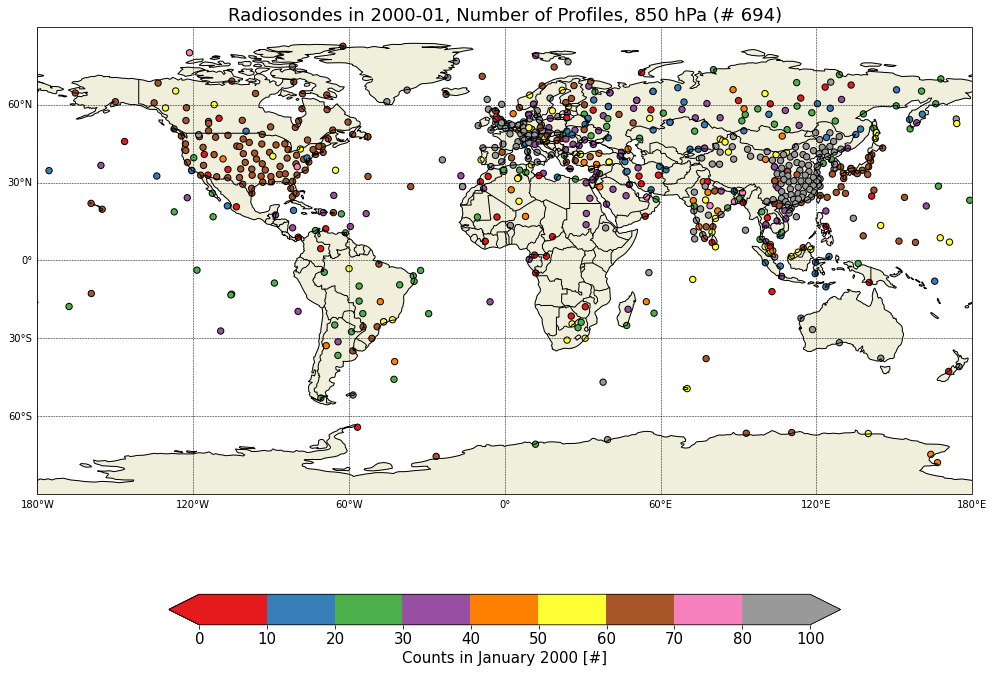

In [31]:
with plt.style.context({'font.size': 15}):

    #
    # Define the Plot
    #
    plt.figure(figsize=(16,10))
    ax = plt.subplot(projection=ccrs.PlateCarree());
    #
    # Add Metainformation
    #
    ax.add_feature(cpy.feature.LAND, zorder=0)
    ax.add_feature(cpy.feature.BORDERS, zorder=1)
    ax.add_feature(cpy.feature.COASTLINE, zorder=1)
    #
    # Plot the Values
    #
    cs = ax.scatter(plotdata.lon.values, plotdata.lat.values, 
                    s=40,
                    c=np.digitize(plotdata.ta.values,[0,10,20,30,40,50,60,70,80,100]),
                    edgecolor='k',
                    transform=ccrs.PlateCarree(),
                    cmap=plt.cm.get_cmap('Set1'));
    #
    # Colorbar
    #
    cb = plt.colorbar(cs, ax=ax, extend='both', orientation='horizontal', shrink=0.6)
    cb.set_label("Counts in January 2000 [#]")
    cb.ax.set_xticklabels([0,10,20,30,40,50,60,70,80,100])
    ax.set_title("Radiosondes in 2000-01, Number of Profiles, 850 hPa (# {})".format(plotdata.ta.count('sonde').item()));
    ax.set_global()
    #
    # Gird lines
    #
    gl = ax.gridlines(draw_labels=True, xlocs=None, ylocs=None,
                      linewidth=0.5, linestyle='--', color='k')
    gl.xformatter = cpy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cpy.mpl.gridliner.LATITUDE_FORMATTER
    gl.xlabels_top = False
    gl.ylabels_right = False
    tight_layout()

# Request a timeseries and convert to cube


Tasks:
* One Station: `10391`
* Datetime range: `20000101 - 20191231`
* One variables: `temperature`
* Background Departures: `obs_minus_bg, obs_minus_an, bias_estimate`
* Standard pressure levels (#16)


In [32]:
t0 = time.time()
# Start Request
r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
               {
                   'variable': ["air_temperature"],
                   'period': '2000-01-01/2019-12-31',
                   'pressure_level':  [10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 700, 850, 925, 1000],
                   'statid': '10393',
                   'fbstats': ['obs_minus_bg', 'obs_minus_an', 'bias_estimate']
               })
# Start Download
r.download(target='download.zip')
# Check file size
assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
# Unzip the Data Stream
z = zipfile.ZipFile('download.zip')
print("Unzipping retrieved files: to ./exampla_data/5")
print(z.namelist())
z.extractall(path='./example_data/5')
z.close()
os.remove('download.zip')
print("Time elapsed: ", time.time()-t0, "s")

2020-07-09 15:49:35,188 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-07-09 15:49:35,479 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1594301639.3252048-16901-11-8d8b622d-d316-411b-9426-25bca3ad8706.zip to download.zip (4.5M)
2020-07-09 15:49:36,307 INFO Download rate 5.5M/s   


Unzipping retrieved files: to ./exampla_data/5
['dest_0-20000-0-10393_air_temperature.nc']
Time elapsed:  1.161588430404663 s


## Conversion Function from ragged array to cube

This function can also be found here: [cds-backend](https://github.com/MBlaschek/CEUAS/tree/master/CEUAS/public/cds-backend/code)

In [33]:
sys.path.append('../cds-backend/code/')
from read_to_cube import read_ragged_array_to_cube

## Read NetCDF to xarray

In [34]:
tdata = xr.load_dataset('example_data/5/dest_0-20000-0-10393_air_temperature.nc')

In [35]:
print(tdata)

<xarray.Dataset>
Dimensions:           (obs: 453683, string10: 10, trajectory: 29256)
Coordinates:
    lat               (obs) float32 52.22 52.22 52.22 ... 52.2093 52.2093
    lon               (obs) float32 14.12 14.12 14.12 ... 14.12041 14.12041
  * obs               (obs) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    plev              (obs) float32 2000.0 3000.0 5000.0 ... 92500.0 100000.0
  * string10          (string10) |S1 b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
    time              (obs) datetime64[ns] 2000-01-01T05:00:00 ... 2019-12-31T16:45:10
  * trajectory        (trajectory) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Data variables:
    ta                (obs) float32 201.7 203.1 207.1 ... 272.77 272.84 278.17
    trajectory_index  (obs) int32 0 0 0 0 0 0 ... 29255 29255 29255 29255 29255
    trajectory_label  (trajectory, string10) |S1 b'0' b'0' b'0' ... b'4' b'0'
Attributes:
    primary_id:    0-20000-0-10393
    station_name:  LINDENBERG (10393-0)
    Conv

## Read NetCDF to xarray cube

In [36]:
%time cube = read_ragged_array_to_cube('example_data/5/dest_0-20000-0-10393_air_temperature.nc')

2020-07-09 15:49:36,859 - read_to_cube | read_ragged_array_to_cube - WARNING - non standard pressure levels problem
2020-07-09 15:49:36,859 WARNING non standard pressure levels problem


CPU times: user 362 ms, sys: 136 ms, total: 498 ms
Wall time: 408 ms


In [37]:
print(cube)

<xarray.Dataset>
Dimensions:  (hour: 2, plev: 16, time: 7296)
Coordinates:
  * hour     (hour) int64 0 12
  * plev     (plev) int64 10 20 30 50 70 100 150 ... 400 500 700 850 925 1000
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2019-12-31
Data variables:
    lat      (time) float32 52.22 52.220005 52.22 ... 52.2093 52.2093 52.209297
    lon      (time) float32 14.12 14.119999 14.12 ... 14.12041 14.120409
    obs      (hour, plev, time) float32 0.0 nan 0.0 nan 0.0 ... 0.0 0.0 0.0 0.0
    ta       (hour, plev, time) float32 202.3 nan nan ... 272.83 279.81 278.17
Attributes:
    Conventions:   CF-1.7
    featureType:   trajectory
    history:       Created by Copernicus Early Upper Air Service Version 0, 0...
    license:       https://apps.ecmwf.int/datasets/licences/copernicus/
    primary_id:    0-20000-0-10393
    source:        radiosonde
    station_name:  LINDENBERG (10393-0)


## Plot a timeseries

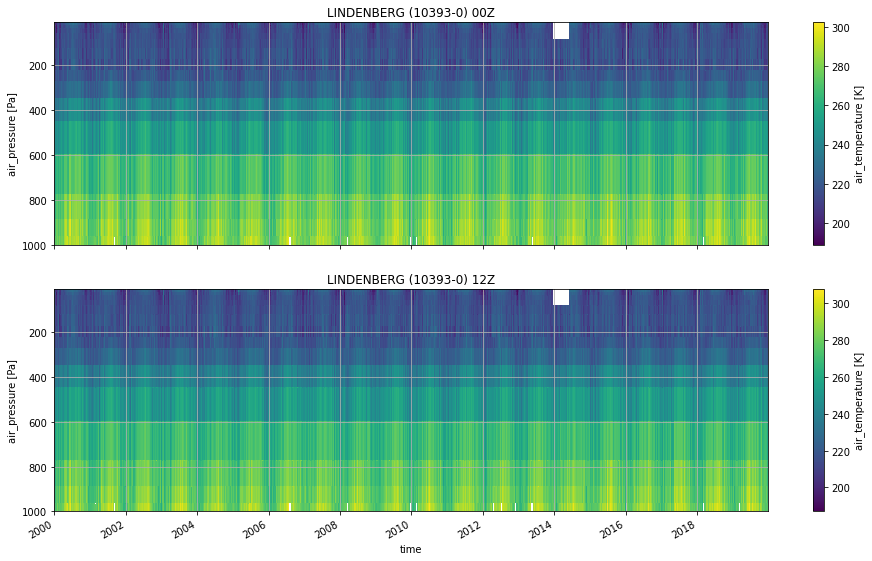

In [38]:
#
# Plotting
#
f, [ax,ay] = subplots(2,1, sharex=True, sharey=True, figsize=(16,9))
cube.sel(hour=0).ta.plot(x='time', y='plev', ax=ax)
cube.sel(hour=12).ta.plot(x='time', y='plev', ax=ay)
ax.grid()
ax.set_xlabel('')
ay.grid()
ax.set_ylim(1000,10)
ax.set_title("{} {:02d}Z".format(cube.attrs['station_name'], 0));
ay.set_title("{} {:02d}Z".format(cube.attrs['station_name'], 12));

## Plot a profile

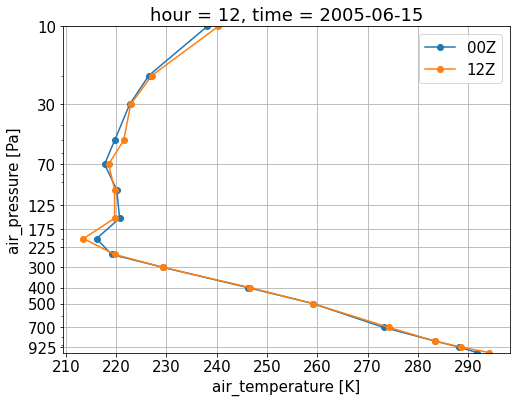

In [39]:
with plt.style.context({'font.size': 15,'figure.figsize':(8,6)}):

    cube.sel(hour=0, time='2005-06-15').ta.plot(y='plev', marker='o', label='00Z')
    cube.sel(hour=12, time='2005-06-15').ta.plot(y='plev', marker='o', label='12Z')
    ylim(1000,10)
    grid()
    legend()
    yscale('log')
    yticks(ticks=yplevs/100, labels=map("{:.0f}".format,yplevs/100));